In [1]:


# Cell 1: Import libraries and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [5]:
# Cell 2: Load configuration and display project info
import sys
import os

sys.path.append(os.path.abspath("../scripts"))

from config import APP_IDS, BANK_NAMES, TASK1_REQUIREMENTS

print("🎯 TASK 1: BANK REVIEWS ANALYSIS")
print("=" * 50)
print("📱 Target Ethiopian Banks:")
for bank_code, bank_name in BANK_NAMES.items():
    print(f"  - {bank_name} ({bank_code})")
print(f"\n📊 Project Requirements:")
print(f"  - Minimum reviews per bank: {TASK1_REQUIREMENTS['min_reviews_per_bank']}")
print(f"  - Total minimum reviews: {TASK1_REQUIREMENTS['total_min_reviews']}")
print(f"  - Maximum data errors: {TASK1_REQUIREMENTS['max_data_errors']*100}%")

✓ Created: data/raw
✓ Created: data/processed
✓ Created: logs
🎯 TASK 1: BANK REVIEWS ANALYSIS
📱 Target Ethiopian Banks:
  - Commercial Bank of Ethiopia (CBE)
  - Bank of Abyssinia (BOA)
  - Dashen Bank (DASHEN)

📊 Project Requirements:
  - Minimum reviews per bank: 400
  - Total minimum reviews: 1200
  - Maximum data errors: 5.0%


In [7]:
# Cell 3: Load and explore raw data
try:
    df_raw = pd.read_csv('../data/raw/reviews_raw_20251127_170649.csv')
    print(f"✅ Loaded {len(df_raw)} raw reviews")
    
    print("\n📊 RAW DATA OVERVIEW:")
    print("=" * 40)
    print(f"Shape: {df_raw.shape}")
    print(f"Columns: {list(df_raw.columns)}")
    
    print("\nFirst 3 rows:")
    display(df_raw.head(3))
    
except FileNotFoundError:
    print("❌ Raw data not found. Please run scraper.py first")
    df_raw = pd.DataFrame()

✅ Loaded 10056 raw reviews

📊 RAW DATA OVERVIEW:
Shape: (10056, 9)
Columns: ['review_id', 'review_text', 'rating', 'date', 'bank', 'source', 'thumbs_up', 'review_created_version', 'timestamp']

First 3 rows:


,review_id,review_text,rating,date,bank,source,thumbs_up,review_created_version,timestamp
0,1ebb9f31-ce77-4149-826a-697d986e9ff1,"WHAT A USELESS APP! Transfers, wallet payments...",1,2025-09-13,CBE,Google Play Store,935,5.2.1,2025-11-27 17:06:22
1,6c72590a-6064-4aac-a5b5-a23df953162d,"Most of the time when I try to open the app, i...",2,2025-09-24,CBE,Google Play Store,59,5.2.1,2025-11-27 17:06:22
2,651c86bc-2cf3-436e-a85c-39c55709db15,I use the Commercial Bank of Ethiopia mobile a...,5,2025-08-22,CBE,Google Play Store,1127,5.2.1,2025-11-27 17:06:22


In [8]:
# Cell 4: Data quality assessment
if not df_raw.empty:
    print("🔍 DATA QUALITY ASSESSMENT")
    print("=" * 50)
    
    # Missing values
    missing_data = df_raw.isnull().sum()
    missing_percent = (missing_data / len(df_raw)) * 100
    
    print("Missing Values:")
    for col, count in missing_data.items():
        if count > 0:
            print(f"  ❌ {col}: {count} missing ({missing_percent[col]:.2f}%)")
        else:
            print(f"  ✅ {col}: No missing values")
    
    # Duplicates
    duplicates = df_raw.duplicated(subset=['review_text', 'bank']).sum()
    print(f"\nDuplicate Reviews: {duplicates} ({duplicates/len(df_raw)*100:.2f}%)")
    
    # Data types
    print(f"\nData Types:")
    print(df_raw.dtypes)

🔍 DATA QUALITY ASSESSMENT
Missing Values:
  ✅ review_id: No missing values
  ❌ review_text: 7 missing (0.07%)
  ✅ rating: No missing values
  ✅ date: No missing values
  ✅ bank: No missing values
  ✅ source: No missing values
  ✅ thumbs_up: No missing values
  ❌ review_created_version: 1924 missing (19.13%)
  ✅ timestamp: No missing values

Duplicate Reviews: 2448 (24.34%)

Data Types:
review_id                 object
review_text               object
rating                     int64
date                      object
bank                      object
source                    object
thumbs_up                  int64
review_created_version    object
timestamp                 object
dtype: object


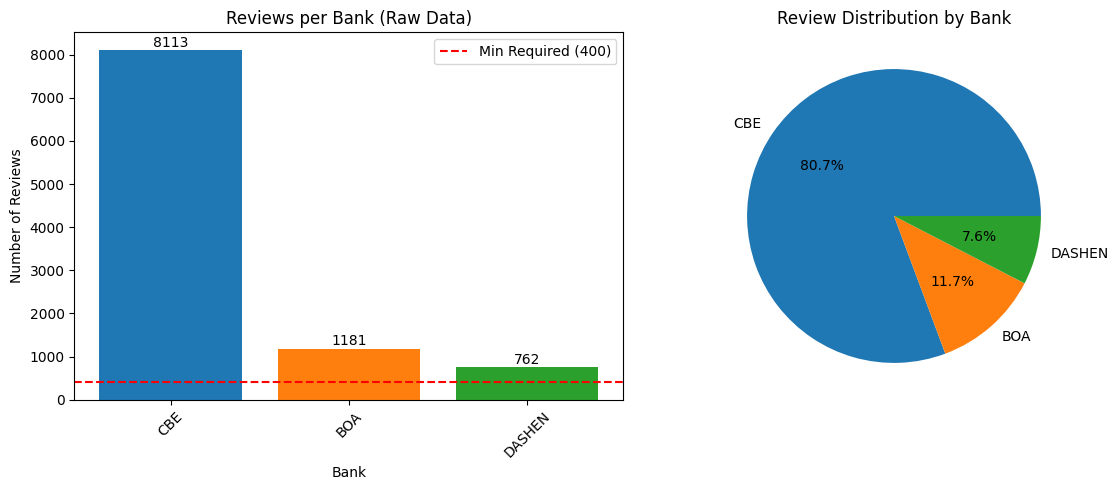

📱 Reviews per Bank Analysis:
  ✅ Commercial Bank of Ethiopia: 8113 reviews
  ✅ Bank of Abyssinia: 1181 reviews
  ✅ Dashen Bank: 762 reviews


In [9]:
# Cell 5: Reviews distribution by bank
if not df_raw.empty:
    plt.figure(figsize=(12, 5))
    
    bank_counts = df_raw['bank'].value_counts()
    
    plt.subplot(1, 2, 1)
    bars = plt.bar(bank_counts.index, bank_counts.values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    plt.title('Reviews per Bank (Raw Data)')
    plt.xlabel('Bank')
    plt.ylabel('Number of Reviews')
    plt.xticks(rotation=45)
    
    # Add requirement line and value labels
    plt.axhline(y=TASK1_REQUIREMENTS['min_reviews_per_bank'], color='red', 
                linestyle='--', label=f'Min Required ({TASK1_REQUIREMENTS["min_reviews_per_bank"]})')
    
    # Add value labels on bars
    for bar, count in zip(bars, bank_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                f'{count}', ha='center', va='bottom')
    
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.pie(bank_counts.values, labels=bank_counts.index, autopct='%1.1f%%', 
            colors=['#1f77b4', '#ff7f0e', '#2ca02c'])
    plt.title('Review Distribution by Bank')
    
    plt.tight_layout()
    plt.show()
    
    print("📱 Reviews per Bank Analysis:")
    for bank, count in bank_counts.items():
        status = "✅" if count >= TASK1_REQUIREMENTS['min_reviews_per_bank'] else "❌"
        bank_name = BANK_NAMES.get(bank, bank)
        print(f"  {status} {bank_name}: {count} reviews")

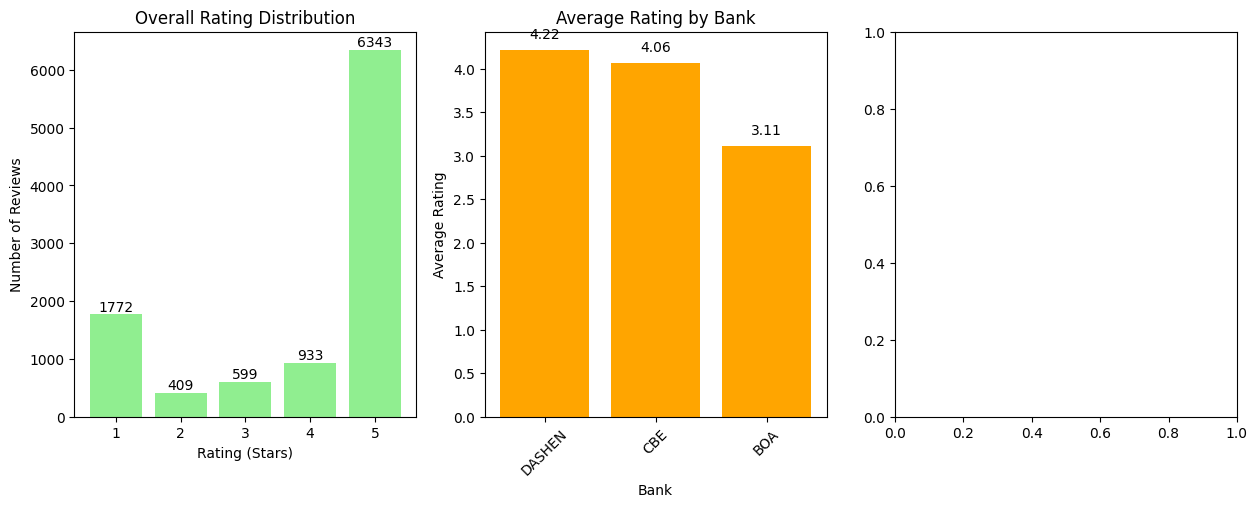

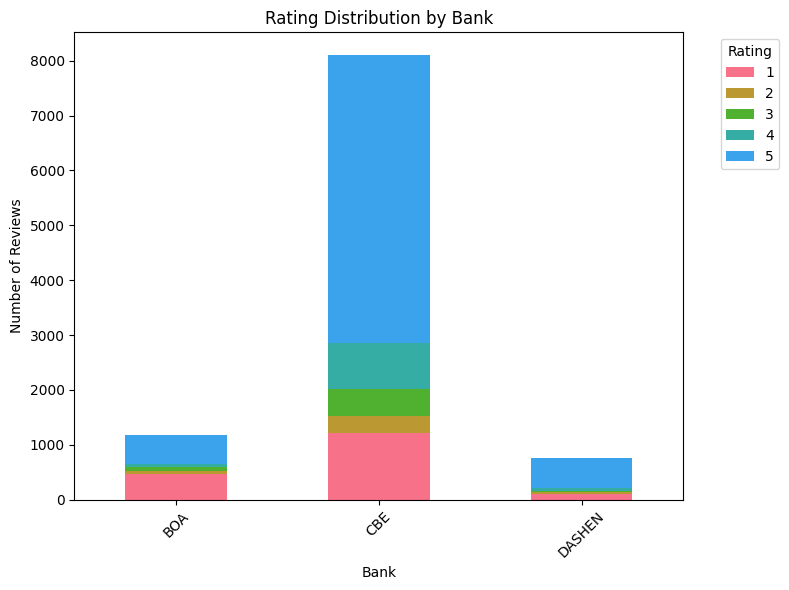

⭐ Rating Statistics:
  Overall Average Rating: 3.96
  Overall Rating Std Dev: 1.56
  Most Common Rating: 5 stars

Average Ratings by Bank:
  - Dashen Bank: 4.22 stars
  - Commercial Bank of Ethiopia: 4.06 stars
  - Bank of Abyssinia: 3.11 stars


In [10]:
# Cell 6: Rating distribution analysis
if not df_raw.empty:
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    rating_counts = df_raw['rating'].value_counts().sort_index()
    bars = plt.bar(rating_counts.index, rating_counts.values, color='lightgreen')
    plt.title('Overall Rating Distribution')
    plt.xlabel('Rating (Stars)')
    plt.ylabel('Number of Reviews')
    
    # Add value labels
    for bar, count in zip(bars, rating_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                f'{count}', ha='center', va='bottom')
    
    plt.subplot(1, 3, 2)
    # Average rating by bank
    avg_ratings = df_raw.groupby('bank')['rating'].mean().sort_values(ascending=False)
    bars = plt.bar(avg_ratings.index, avg_ratings.values, color='orange')
    plt.title('Average Rating by Bank')
    plt.xlabel('Bank')
    plt.ylabel('Average Rating')
    plt.xticks(rotation=45)
    
    # Add value labels
    for bar, rating in zip(bars, avg_ratings.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                f'{rating:.2f}', ha='center', va='bottom')
    
    plt.subplot(1, 3, 3)
    # Rating distribution by bank
    rating_by_bank = pd.crosstab(df_raw['bank'], df_raw['rating'])
    rating_by_bank.plot(kind='bar', stacked=True, figsize=(8, 6))
    plt.title('Rating Distribution by Bank')
    plt.xlabel('Bank')
    plt.ylabel('Number of Reviews')
    plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("⭐ Rating Statistics:")
    print(f"  Overall Average Rating: {df_raw['rating'].mean():.2f}")
    print(f"  Overall Rating Std Dev: {df_raw['rating'].std():.2f}")
    print(f"  Most Common Rating: {df_raw['rating'].mode().iloc[0]} stars")
    print(f"\nAverage Ratings by Bank:")
    for bank, avg_rating in avg_ratings.items():
        bank_name = BANK_NAMES.get(bank, bank)
        print(f"  - {bank_name}: {avg_rating:.2f} stars")

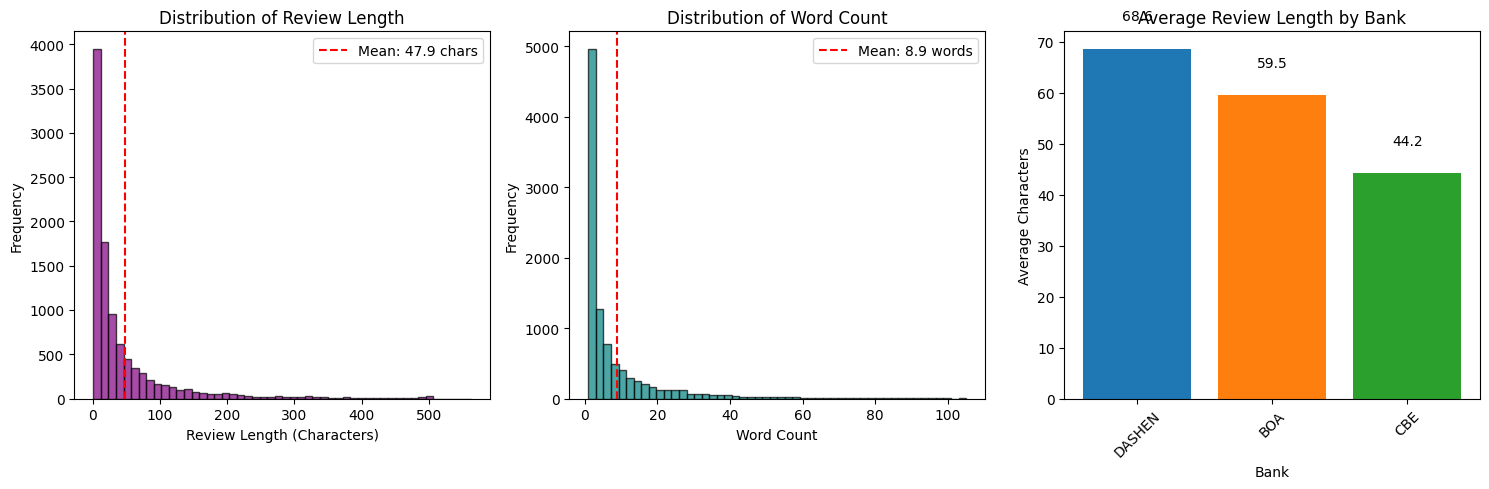

📝 Text Statistics:
  Average Review Length: 47.9 characters
  Average Word Count: 8.9 words
  Longest Review: 563.0 characters
  Shortest Review: 1.0 characters

Average Review Length by Bank:
  - Dashen Bank: 68.6 characters
  - Bank of Abyssinia: 59.5 characters
  - Commercial Bank of Ethiopia: 44.2 characters


In [11]:
# Cell 7: Text analysis - Review length
if not df_raw.empty:
    df_raw['review_length'] = df_raw['review_text'].str.len()
    df_raw['word_count'] = df_raw['review_text'].str.split().str.len()
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(df_raw['review_length'].dropna(), bins=50, alpha=0.7, color='purple', edgecolor='black')
    plt.axvline(df_raw['review_length'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_raw["review_length"].mean():.1f} chars')
    plt.title('Distribution of Review Length')
    plt.xlabel('Review Length (Characters)')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.hist(df_raw['word_count'].dropna(), bins=50, alpha=0.7, color='teal', edgecolor='black')
    plt.axvline(df_raw['word_count'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_raw["word_count"].mean():.1f} words')
    plt.title('Distribution of Word Count')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    # Review length by bank
    length_by_bank = df_raw.groupby('bank')['review_length'].mean().sort_values(ascending=False)
    bars = plt.bar(length_by_bank.index, length_by_bank.values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    plt.title('Average Review Length by Bank')
    plt.xlabel('Bank')
    plt.ylabel('Average Characters')
    plt.xticks(rotation=45)
    
    # Add value labels
    for bar, length in zip(bars, length_by_bank.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                f'{length:.1f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print("📝 Text Statistics:")
    print(f"  Average Review Length: {df_raw['review_length'].mean():.1f} characters")
    print(f"  Average Word Count: {df_raw['word_count'].mean():.1f} words")
    print(f"  Longest Review: {df_raw['review_length'].max()} characters")
    print(f"  Shortest Review: {df_raw['review_length'].min()} characters")
    print(f"\nAverage Review Length by Bank:")
    for bank, avg_length in length_by_bank.items():
        bank_name = BANK_NAMES.get(bank, bank)
        print(f"  - {bank_name}: {avg_length:.1f} characters")

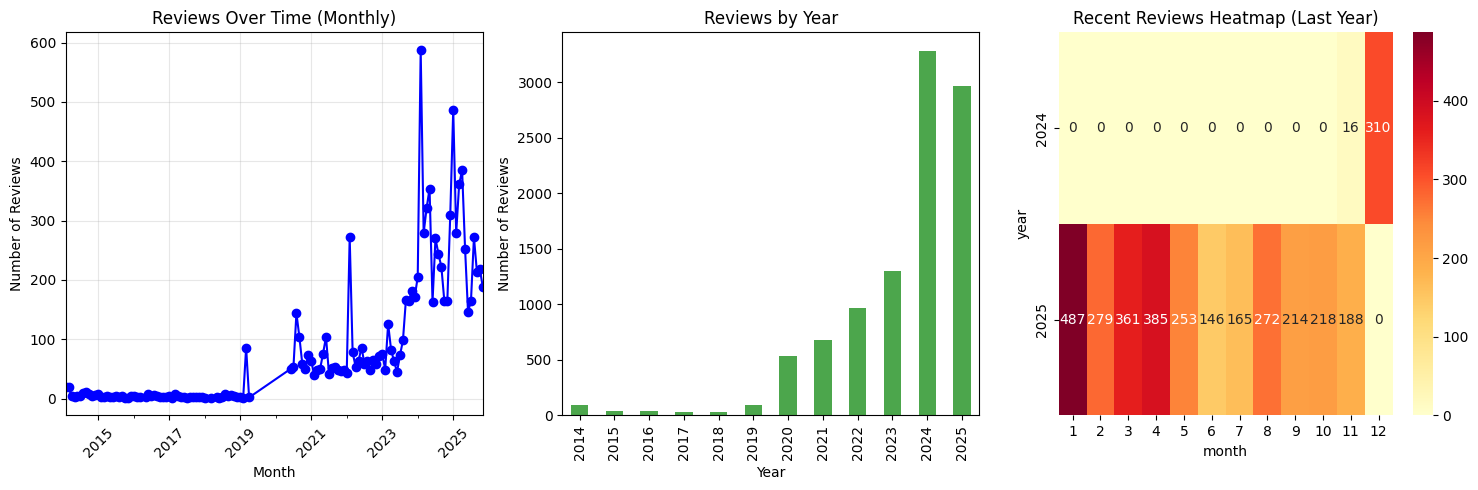

📅 Date Analysis:
  Earliest Review: 2014-02-17 00:00:00
  Latest Review: 2025-11-26 00:00:00
  Date Range: 4300 days
  Total Reviews with Valid Dates: 10056
  Reviews with Invalid Dates: 0
  Average Reviews per Month: 79.8
  Most Active Month: 2024-02 (588 reviews)


In [13]:
# Cell 8: Date analysis
if not df_raw.empty and 'date' in df_raw.columns:
    df_raw['date_parsed'] = pd.to_datetime(df_raw['date'], errors='coerce')
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    monthly_reviews = df_raw.groupby(df_raw['date_parsed'].dt.to_period('M')).size()
    monthly_reviews.plot(kind='line', marker='o', color='blue')
    plt.title('Reviews Over Time (Monthly)')
    plt.xlabel('Month')
    plt.ylabel('Number of Reviews')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    # Reviews by year
    yearly_reviews = df_raw.groupby(df_raw['date_parsed'].dt.year).size()
    yearly_reviews.plot(kind='bar', color='green', alpha=0.7)
    plt.title('Reviews by Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Reviews')
    
    plt.subplot(1, 3, 3)
    # Recent reviews heatmap (last year)
    one_year_ago = datetime.now() - pd.DateOffset(years=1)
    recent_reviews = df_raw[df_raw['date_parsed'] >= one_year_ago]
    if not recent_reviews.empty:
        recent_reviews['month'] = recent_reviews['date_parsed'].dt.month
        recent_reviews['year'] = recent_reviews['date_parsed'].dt.year
        heatmap_data = recent_reviews.pivot_table(
            index='year', columns='month', values='review_id', aggfunc='count', fill_value=0
        )
        sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd')
        plt.title('Recent Reviews Heatmap (Last Year)')
    else:
        # If no recent reviews, show a message or alternative plot
        plt.text(0.5, 0.5, 'No recent reviews\n(within last year)', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Recent Reviews Heatmap (Last Year)')
    
    plt.tight_layout()
    plt.show()
    
    print("📅 Date Analysis:")
    print(f"  Earliest Review: {df_raw['date_parsed'].min()}")
    print(f"  Latest Review: {df_raw['date_parsed'].max()}")
    print(f"  Date Range: {(df_raw['date_parsed'].max() - df_raw['date_parsed'].min()).days} days")
    print(f"  Total Reviews with Valid Dates: {df_raw['date_parsed'].notna().sum()}")
    print(f"  Reviews with Invalid Dates: {df_raw['date_parsed'].isna().sum()}")
    
    # Additional date statistics
    print(f"  Average Reviews per Month: {monthly_reviews.mean():.1f}")
    print(f"  Most Active Month: {monthly_reviews.idxmax()} ({monthly_reviews.max()} reviews)")